# Clean, stitch and analyse red wine data scraped from LCBO and Vivino

This notebook uses data scraped from LCBO and Vivino websites to help a Canadian  decide which red wine offers the most value for a prescribed price point.

The Liquor Control Board of Ontario ("LCBO") is a Crown corporation that retails and distributes alcoholic beverages throughout the Canadian province of Ontario. It regulates the importation and pricing of alcoholic beverages within Ontario.

Vivino is an online wine marketplace and app with a database of over 10 million wines and over 35 million users. It is one of the leading websites for reviews and ratings for wine.

Combining the price information from the LCBO with the rating information would enable an Ontarian red-wine consumer to make choices around their purchases of red wine that offer value. Even if the value is perceived value, it makes a consumer feel better about their purchase. Increased consumer confidence is likely to lead to increased consumption from a general economic standpoint.

## Load required packages and data from scraped .csv files

In [1]:
# Load packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Load interesting package to help with matching of bottle titles from LCBO to Vivino. 
# It uses Levenshtein Distance to calculate differences between sequences used for checking bottle names from 
# lcbo.com vs vivino.com.
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [3]:
# Load .csv files as dataframes

# dataframe dfl for LCBO data
dfl = pd.read_csv('lcbo_redwine.csv')

# datafram dfv for vivno data
dfv = pd.read_csv('vivino_redwine.csv')

In [4]:
# Check the LCBO df
dfl.head()

,name,region,size-mL,container,price,critic,critic_score
0,Château Lafite-Rothschild 1986,"Bordeaux, France",1500,bottle,9990.0,RP,98.0
1,Masseto,"Tuscany, Italy",6000,bottle,9950.0,none,0.0
2,Château Mouton Rothschild 2005,"Bordeaux, France",3000,bottle,6690.0,RP,98.0
3,Château Margaux 1983,"Bordeaux, France",1500,bottle,6400.0,WS,98.0
4,Domaine Leroy Clos de la Roche Grand Cru 2013,"Burgundy, France",750,bottle,5970.0,RP,93.0


In [5]:
# Check the vivino df
dfv.head()

,title,region,country,score,num_reviews
0,Château Lafite Rothschild Count De Lafite Bord...,Bordeaux,France,4.6,14
1,Masseto Toscana,Toscana,Italy,4.7,12022
2,Château Mouton Rothschild Aile d'Argent Blanc ...,Bordeaux,France,4.2,3382
3,G.G. Ochsner Chateau Margaux Bordeaux,Médoc,France,0.0,0
4,Leroy Clos de la Roche Grand Cru,Clos de la Roche Grand Cru,France,4.7,205


## Analyse and clean data and stitch Vivino data to LCBO data

### First clean and analyse LCBO data

In [6]:
# Summary stats of continuous variables
dfl.describe()

,size-mL,price,critic_score
count,6089.000000,6089.000000,6075.000000
mean,817.182789,109.354533,38.682469
std,404.069473,364.336190,46.024468
min,2.000000,2.350000,0.000000
25%,750.000000,18.950000,0.000000
50%,750.000000,30.750000,0.000000
75%,750.000000,73.000000,93.000000
max,6000.000000,9990.000000,100.000000


In [7]:
# Explore minimum size of 2ml, looks to be incorrect
dfl[dfl['size-mL'] == 2]

,name,region,size-mL,container,price,critic,critic_score
1854,Mazzei Ser Lapo Riserva Chianti Classico 2017,"Tuscany, Italy",2,gift,58.95,JS,95.0



<img src="https://www.lcbo.com/content/dam/lcbo/products/016818.jpg/jcr:content/renditions/cq5dam.web.319.319.jpeg" style="height: 300px;">
*Source: LCBO website*

It turns out that this is actually a giftbox consisting of 2 bottles of 750mL of wine. Hence Replace data point with 1500mL

In [8]:
dfl.loc[dfl['size-mL']==2,'size-mL'] = 1500

In [9]:
dfl.describe()

,size-mL,price,critic_score
count,6089.000000,6089.000000,6075.000000
mean,817.428806,109.354533,38.682469
std,404.029094,364.336190,46.024468
min,6.000000,2.350000,0.000000
25%,750.000000,18.950000,0.000000
50%,750.000000,30.750000,0.000000
75%,750.000000,73.000000,93.000000
max,6000.000000,9990.000000,100.000000


In [10]:
# Looks like there are more issues with size. Explore sizes less than 250ml
dfl[dfl['size-mL'] <250]

,name,region,size-mL,container,price,critic,critic_score
1251,Tedeschi Capitel Monte Olmi Amarone della Valp...,"Veneto, Italy",6,bottle,89.00,none,0.0
1539,Osborne Solaz Tempranillo Cabernet Offer,"Rueda, Spain",6,bottle,72.00,none,0.0
1941,Buscado Vivo o Muerto La Verdad Gualtallary 2016,"Mendoza, Argentina",6,bottle,55.00,TAT,96.0
2644,Bell'Aja Bolgheri 2017,"Tuscany, Italy",6,bottle,37.95,JS,91.0
6080,Copa di Vino Cabernet Sauvignon,"Oregon, USA",200,bottle,4.90,none,0.0
6081,Copa di Vino Merlot,"Oregon, USA",200,bottle,4.90,none,0.0
6086,Peller Family Vineyards Cabernet Merlot,"Ontario, Canada",200,bottle,3.75,none,0.0
6088,Ciao Sangria,"Veneto, Italy",200,can,2.35,none,0.0


Luckily there are only 4 data points to fix (200mL bottles are correct but the 4 with 6 is actually 6 bottles of certain size)

1) Tedeschi is 6 x 125mL
2) Osborne is 6 x 750mL
3) Buscado is 6 x 125mL
4) Bellaja is 6 x 125mL


In [11]:
# Update correct size in mL for gift packs or offers
dfl.loc[1251, 'size-mL'] = 6*125
dfl.loc[1539, 'size-mL'] = 6*750
dfl.loc[1941, 'size-mL'] = 6*125
dfl.loc[2644, 'size-mL'] = 6*125

In [12]:
# Create new variable which normalises price per mL called unit_price
dfl['unit_price'] = dfl['price'] / dfl['size-mL']
dfl.head()

,name,region,size-mL,container,price,critic,critic_score,unit_price
0,Château Lafite-Rothschild 1986,"Bordeaux, France",1500,bottle,9990.0,RP,98.0,6.660000
1,Masseto,"Tuscany, Italy",6000,bottle,9950.0,none,0.0,1.658333
2,Château Mouton Rothschild 2005,"Bordeaux, France",3000,bottle,6690.0,RP,98.0,2.230000
3,Château Margaux 1983,"Bordeaux, France",1500,bottle,6400.0,WS,98.0,4.266667
4,Domaine Leroy Clos de la Roche Grand Cru 2013,"Burgundy, France",750,bottle,5970.0,RP,93.0,7.960000


In [13]:
# Everything looks good for continuous variables. When professional critic scores are not available, they have been set to zero
dfl.describe()

,size-mL,price,critic_score,unit_price
count,6089.000000,6089.000000,6075.000000,6089.000000
mean,818.533421,109.354533,38.682469,0.117551
std,406.245591,364.336190,46.024468,0.298816
min,200.000000,2.350000,0.000000,0.007733
25%,750.000000,18.950000,0.000000,0.025267
50%,750.000000,30.750000,0.000000,0.040467
75%,750.000000,73.000000,93.000000,0.096467
max,6000.000000,9990.000000,100.000000,7.960000


In [14]:
# Value count of categorical variables
categorical = ['name', 'region', 'container', 'critic']

for feature in categorical:
    print(dfl[feature].value_counts())
    print('')

Castelgiocondo Ripe al Convento Riserva Brunello di Montalcino 2013    4
Peller Family Vineyards Cabernet Merlot                                4
Château Palmer                                                         4
Bodacious Smooth Red                                                   4
Solaia 2008                                                            3
                                                                      ..
IRIS Toscano Rosso IGT 2015                                            1
Castillo de Mendoza Autor Organic 2013                                 1
Rosso del Senatore IGT 2015                                            1
Hedges Red Mountain Cabernet Sauvignon 2016                            1
Obsession Red Blend California                                         1
Name: name, Length: 5890, dtype: int64

California, USA         624
Tuscany, Italy          466
Bordeaux, France        449
Ontario, Canada         333
Burgundy, France        293
                 

In [15]:
# Split region into sub-region and country
dfl[['sub_region','country']] = dfl.region.str.split(',',expand=True)

In [16]:
# Value count of categorical variables
categorical = ['sub_region', 'country']

for feature in categorical:
    print(dfl[feature].value_counts())
    print('')

California         624
Tuscany            466
Bordeaux           449
Ontario            333
Burgundy           293
                  ... 
Tasmania             1
Baja California      1
Cahors               1
Terra Alta           1
Serbia               1
Name: sub_region, Length: 187, dtype: int64

 Italy                          1174
 France                         1174
 USA                             776
 Canada                          365
 Australia                       340
 Spain                           325
 Portugal                        263
 Argentina                       160
 Chile                           160
 New Zealand                      71
 South Africa                     70
 Greece                           49
 Germany                          21
 Israel                           19
 Georgia                          11
 Austria                           5
 Bulgaria                          3
 Romania                           1
 Hungary                           1

In [17]:
# Use Sturgess' rule to suggest optimal number of bins based on sample size
int(1 + 3.322 * np.log(dfl.shape[0]))

29

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001601F2E9910>,
      dtype=object)

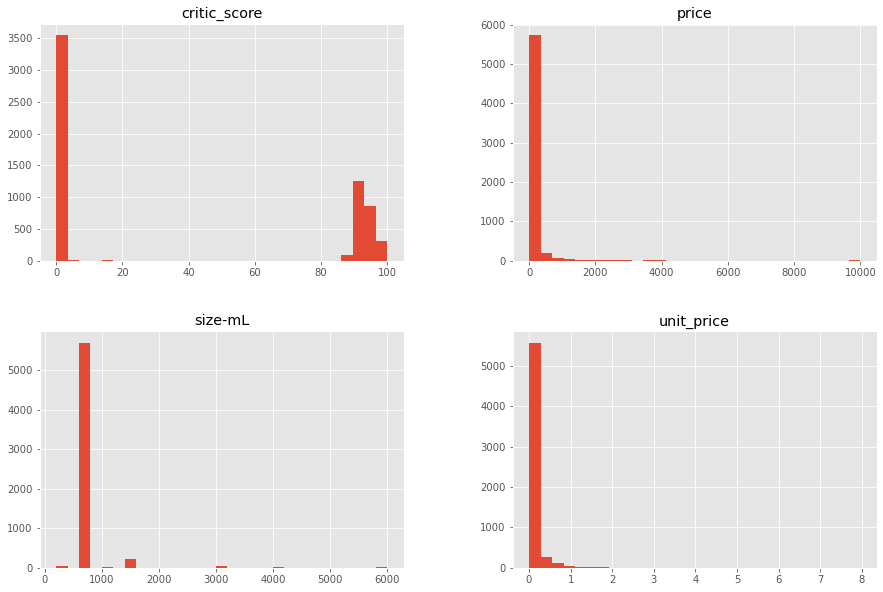

In [18]:
dfl.hist(bins=29, figsize=(15, 10))

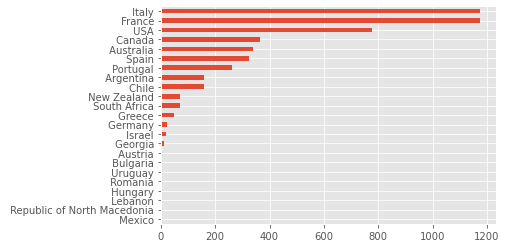

In [19]:
# Chart of item count by country
dfl['country'].value_counts().sort_values(ascending=True).plot(kind='barh')

### Next, clean and analyse Vivino data and stitch with LCBO data

In [20]:
# Summary stats of continuous variables
dfv.describe()

,score,num_reviews
count,6089.000000,6089.000000
mean,3.481228,3585.841846
std,1.169673,9906.982630
min,0.000000,0.000000
25%,3.500000,76.000000
50%,3.800000,467.000000
75%,4.100000,2490.000000
max,4.800000,150466.000000


In [21]:
dfv.head()

,title,region,country,score,num_reviews
0,Château Lafite Rothschild Count De Lafite Bord...,Bordeaux,France,4.6,14
1,Masseto Toscana,Toscana,Italy,4.7,12022
2,Château Mouton Rothschild Aile d'Argent Blanc ...,Bordeaux,France,4.2,3382
3,G.G. Ochsner Chateau Margaux Bordeaux,Médoc,France,0.0,0
4,Leroy Clos de la Roche Grand Cru,Clos de la Roche Grand Cru,France,4.7,205


In [22]:
# Value count of categorical variables
categorical = ['title', 'region', 'country']

for feature in categorical:
    print(dfv[feature].value_counts())
    print('')

missed                                            359
Château La France Bordeaux                         35
Antinori Tenuta Tignanello 'Solaia'                22
Antinori Tenuta Guado al Tasso Matarocchio         21
New Zealand Pinot Noir Marlborough                 19
                                                 ... 
Château Vieux Manoir Bordeaux                       1
Roscato Dark Red Blend                              1
Kings Ridge Pinot Noir                              1
Cafaggio Chianti Classico                           1
Chizay Kagor Limited Edition Special Selection      1
Name: title, Length: 4816, dtype: int64

missed              359
Bordeaux            251
Toscana             196
California          184
Napa Valley         160
                   ... 
Podgorica             1
Monção e Melgaço      1
Baja California       1
Méditerranée          1
Ribatejo              1
Name: region, Length: 718, dtype: int64

Italy                              1324
France              

In [23]:
# Merge dataframes since vivino ratings sourced by LCBO name output
# Create master datafram called df with all the data to be used
df = dfl.merge(dfv, left_index=True, right_index=True)

In [24]:
df.head()

,name,region_x,size-mL,container,price,critic,critic_score,unit_price,sub_region,country_x,title,region_y,country_y,score,num_reviews
0,Château Lafite-Rothschild 1986,"Bordeaux, France",1500,bottle,9990.0,RP,98.0,6.660000,Bordeaux,France,Château Lafite Rothschild Count De Lafite Bord...,Bordeaux,France,4.6,14
1,Masseto,"Tuscany, Italy",6000,bottle,9950.0,none,0.0,1.658333,Tuscany,Italy,Masseto Toscana,Toscana,Italy,4.7,12022
2,Château Mouton Rothschild 2005,"Bordeaux, France",3000,bottle,6690.0,RP,98.0,2.230000,Bordeaux,France,Château Mouton Rothschild Aile d'Argent Blanc ...,Bordeaux,France,4.2,3382
3,Château Margaux 1983,"Bordeaux, France",1500,bottle,6400.0,WS,98.0,4.266667,Bordeaux,France,G.G. Ochsner Chateau Margaux Bordeaux,Médoc,France,0.0,0
4,Domaine Leroy Clos de la Roche Grand Cru 2013,"Burgundy, France",750,bottle,5970.0,RP,93.0,7.960000,Burgundy,France,Leroy Clos de la Roche Grand Cru,Clos de la Roche Grand Cru,France,4.7,205


In [25]:
# Rename columns after merge to distinguish between LCBO and Vivino data
rename_cols = {'name':'lcbo_name', 'region_x':'lcbo_region', 'sub_region':'lcbo_subregion',\
               'country_x':'lcbo_country', 'title':'viv_name', 'region_y':'viv_region',\
               'country_y':'viv_country'}
df = df.rename(columns = rename_cols)

In [26]:
df.head()

,lcbo_name,lcbo_region,size-mL,container,price,critic,critic_score,unit_price,lcbo_subregion,lcbo_country,viv_name,viv_region,viv_country,score,num_reviews
0,Château Lafite-Rothschild 1986,"Bordeaux, France",1500,bottle,9990.0,RP,98.0,6.660000,Bordeaux,France,Château Lafite Rothschild Count De Lafite Bord...,Bordeaux,France,4.6,14
1,Masseto,"Tuscany, Italy",6000,bottle,9950.0,none,0.0,1.658333,Tuscany,Italy,Masseto Toscana,Toscana,Italy,4.7,12022
2,Château Mouton Rothschild 2005,"Bordeaux, France",3000,bottle,6690.0,RP,98.0,2.230000,Bordeaux,France,Château Mouton Rothschild Aile d'Argent Blanc ...,Bordeaux,France,4.2,3382
3,Château Margaux 1983,"Bordeaux, France",1500,bottle,6400.0,WS,98.0,4.266667,Bordeaux,France,G.G. Ochsner Chateau Margaux Bordeaux,Médoc,France,0.0,0
4,Domaine Leroy Clos de la Roche Grand Cru 2013,"Burgundy, France",750,bottle,5970.0,RP,93.0,7.960000,Burgundy,France,Leroy Clos de la Roche Grand Cru,Clos de la Roche Grand Cru,France,4.7,205


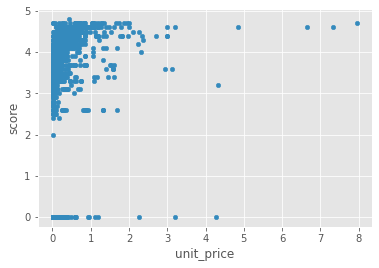

In [27]:
# Chart of item count by country
df.plot(x='unit_price', y='score', kind='scatter')

In [28]:
df[df['score'] >= 4.6].sort_values(by='unit_price')

,lcbo_name,lcbo_region,size-mL,container,price,critic,critic_score,unit_price,lcbo_subregion,lcbo_country,viv_name,viv_region,viv_country,score,num_reviews
6076,Monte Velho Red 2018,"Alentejo, Portugal",375,bottle,6.95,none,0.0,0.018533,Alentejo,Portugal,Arrepiado Velho Amma Red,Alentejo,Portugal,4.7,141
5533,Monte Velho Red 2019,"Alentejo, Portugal",750,bottle,14.05,none,0.0,0.018733,Alentejo,Portugal,Arrepiado Velho Amma Red,Alentejo,Portugal,4.7,141
1859,Arrepiado Tradicao Red Alentejo 2016,"Alentejo, Portugal",750,bottle,58.40,none,0.0,0.077867,Alentejo,Portugal,Arrepiado Velho Amma Red,Alentejo,Portugal,4.7,141
1624,Hagafen Estate Bottled Cabernet Sauvignon 2013,"California, USA",750,bottle,68.90,none,0.0,0.091867,California,USA,Far Niente Estate Bottled Cabernet Sauvignon,Oakville,United States,4.6,11215
1421,Follow the Hand Brunello di Montalcino DOCG 2013,Italy,750,bottle,77.85,none,0.0,0.103800,Italy,None,The Vinum Brunello di Montalcino,Brunello di Montalcino,Italy,4.6,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,Château Lafite-Rothschild 2001,"Bordeaux, France",750,bottle,2400.00,WS,96.0,3.200000,Bordeaux,France,Château Lafite Rothschild Count De Lafite Bord...,Bordeaux,France,4.6,14
12,Maison Leroy Corton-Renardes 2002,"Burgundy, France",750,bottle,3640.00,BH,94.0,4.853333,Burgundy,France,Leroy Corton-Renardes Grand Cru,Corton Grand Cru 'Les Renardes',France,4.6,139
0,Château Lafite-Rothschild 1986,"Bordeaux, France",1500,bottle,9990.00,RP,98.0,6.660000,Bordeaux,France,Château Lafite Rothschild Count De Lafite Bord...,Bordeaux,France,4.6,14
6,Château Lafite-Rothschild 1986,"Bordeaux, France",750,bottle,5500.00,RP,98.0,7.333333,Bordeaux,France,Château Lafite Rothschild Count De Lafite Bord...,Bordeaux,France,4.6,14


In [29]:
df.head()

,lcbo_name,lcbo_region,size-mL,container,price,critic,critic_score,unit_price,lcbo_subregion,lcbo_country,viv_name,viv_region,viv_country,score,num_reviews
0,Château Lafite-Rothschild 1986,"Bordeaux, France",1500,bottle,9990.0,RP,98.0,6.660000,Bordeaux,France,Château Lafite Rothschild Count De Lafite Bord...,Bordeaux,France,4.6,14
1,Masseto,"Tuscany, Italy",6000,bottle,9950.0,none,0.0,1.658333,Tuscany,Italy,Masseto Toscana,Toscana,Italy,4.7,12022
2,Château Mouton Rothschild 2005,"Bordeaux, France",3000,bottle,6690.0,RP,98.0,2.230000,Bordeaux,France,Château Mouton Rothschild Aile d'Argent Blanc ...,Bordeaux,France,4.2,3382
3,Château Margaux 1983,"Bordeaux, France",1500,bottle,6400.0,WS,98.0,4.266667,Bordeaux,France,G.G. Ochsner Chateau Margaux Bordeaux,Médoc,France,0.0,0
4,Domaine Leroy Clos de la Roche Grand Cru 2013,"Burgundy, France",750,bottle,5970.0,RP,93.0,7.960000,Burgundy,France,Leroy Clos de la Roche Grand Cru,Clos de la Roche Grand Cru,France,4.7,205


In [ ]:
fuzz.ratio("this is a test", "this is a test!")

In [ ]:
lines = list(map(lambda s: s.strip(), lines))